In [2]:
import matplotlib.pyplot as plt
import numpy as np
from vishelper import *
from pathlib import Path

In [2]:
dir_path = Path(r"/Users/andrewxie/Documents/TCIG/UWB/UWB1D")

Amplitude bound: 42.39621874804868


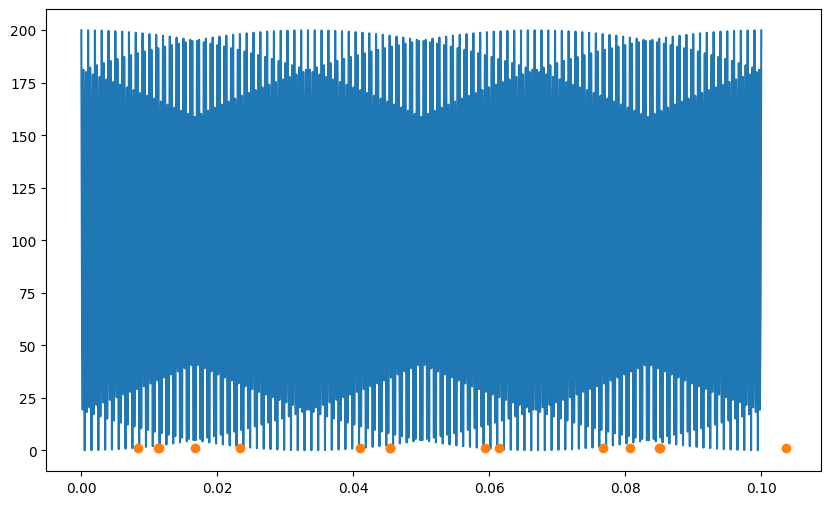

In [ ]:
val = 100
freq = 3E3 # 3 kHz
phase = 0
T = 0.1

# Generate timestamps
timestamps = generateStamps(val, freq, phase, rateSinu, T)
plt.figure(figsize=(10, 6))
t = np.linspace(0, T, 1000)
sinu_signal = rateSinu(t, val, freq, phase)[1]
plt.plot(t, sinu_signal, label='Sinusoidal signal')
plt.plot(timestamps, np.ones_like(timestamps), 'o', label='timestamps (poisson process)')

# Apply deadtime and jitter to the timestamps
# deadtime = 0.1
# jitter = 0.01
# timestamps_deadtime = applyDeadtime(timestamps, deadtime, jitter)
# plt.plot(timestamps_deadtime, 1.1*np.ones_like(timestamps_deadtime), 'o', label='w Deadtime and jitter')
# plt.legend(loc='upper right')
# plt.savefig('deadtime_jitter.png')
# plt.show()



# Compute amplitude bound
percentage_in = 0.95
counts_per_sec = len(timestamps) / T
bound_val = compute_amplitude_bound(percentage_in, counts_per_sec)

print(f'Amplitude bound: {bound_val}')

In [ ]:
def snr_db(n, s):
    return 10 * np.log10(s/n)

12
Amplitude bound: 169.96810952332842


100%|██████████| 12/12 [00:00<00:00, 1819.26it/s]


103
Amplitude bound: 474.5427104299932


100%|██████████| 103/103 [00:00<00:00, 26321.41it/s]


967
Amplitude bound: 1430.9904114296248


100%|██████████| 2/2 [00:00<00:00, 2334.06it/s]


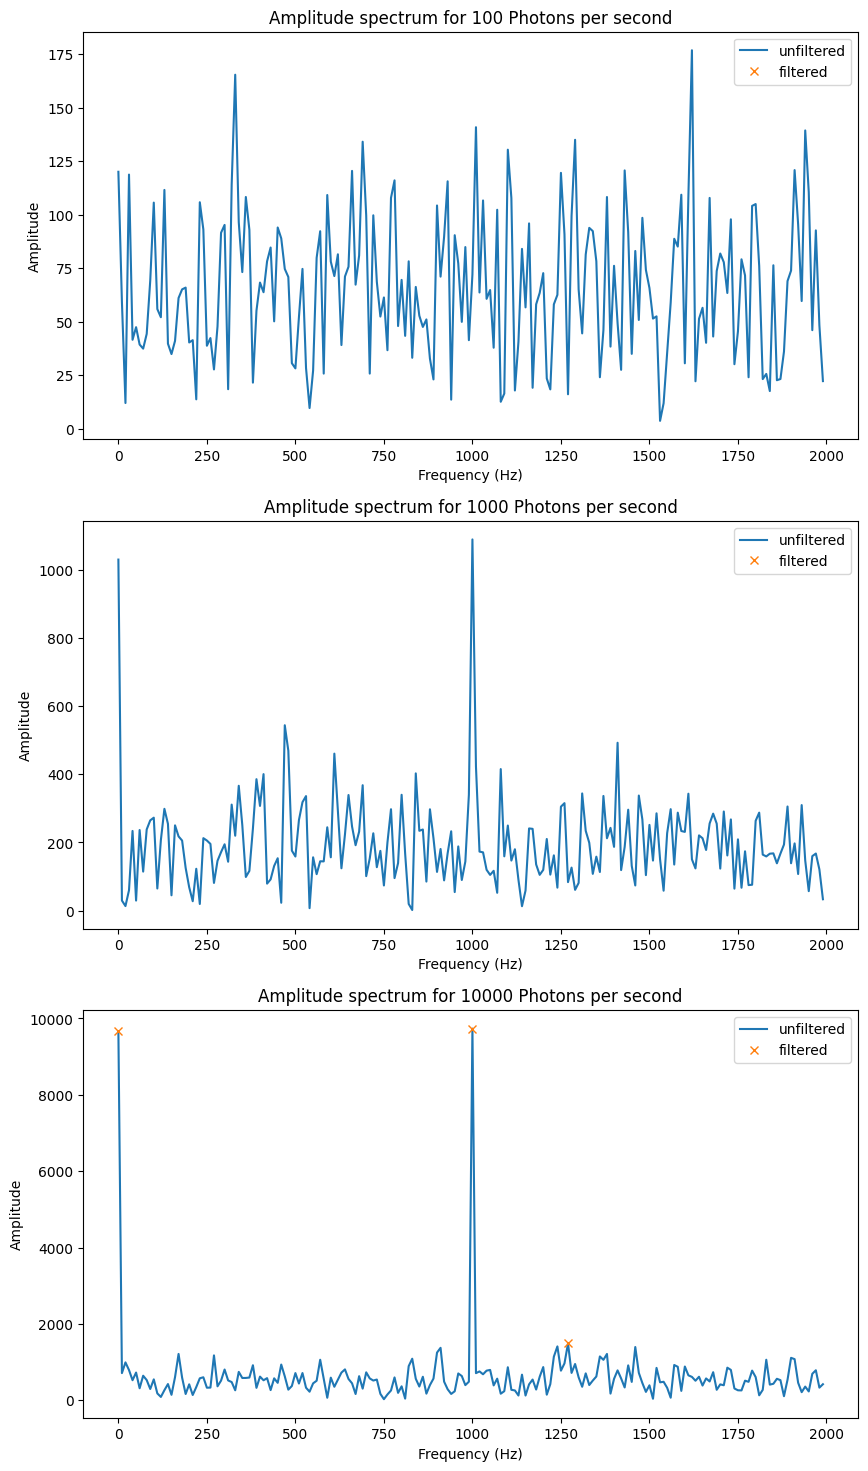

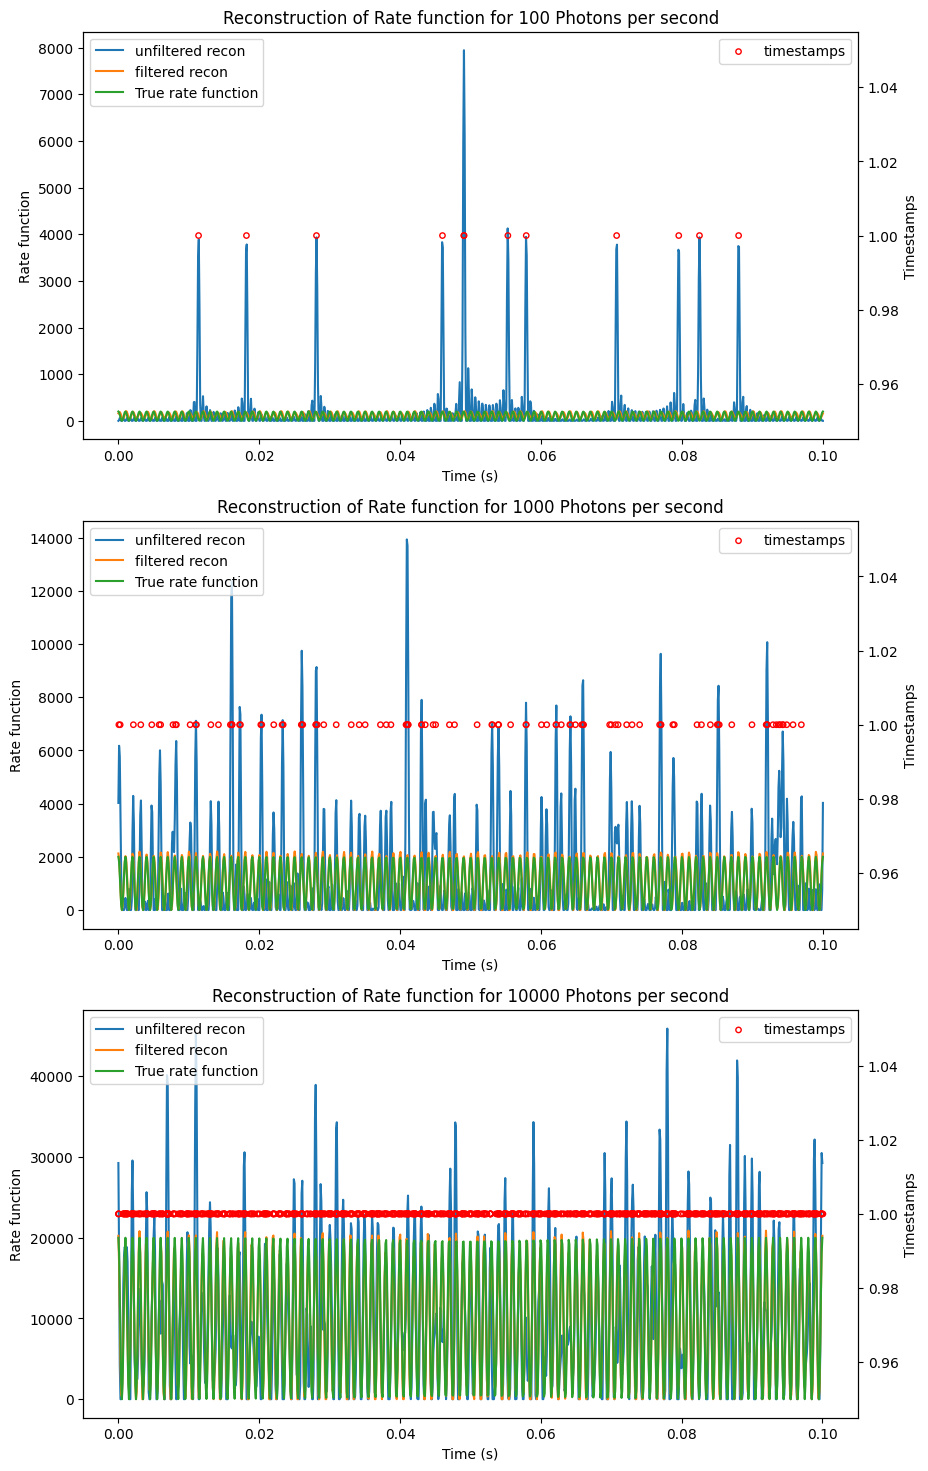

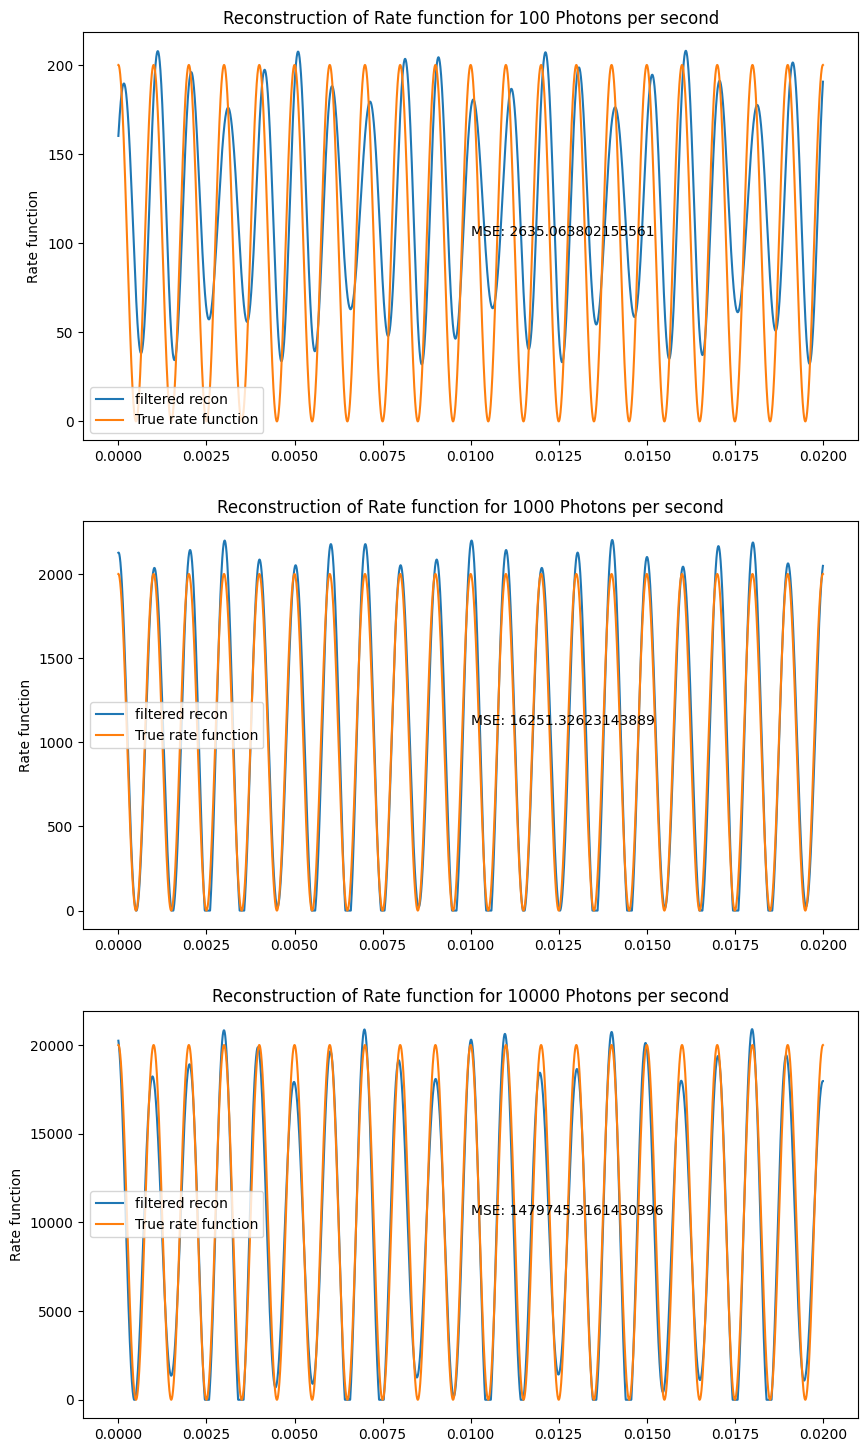

In [4]:
from probe import probe
from utils import (compute_coefficients_sweep_torch, 
                   compute_bound_torch, 
                   compute_amplitude_bound, 
                   reconstruct_rate_function_torch)
import torch
import torch.nn.functional as F

freq = 1E3 # 3 kHz
phase = 0
T = 0.1 # Probe time
ts = torch.linspace(0, T, 1000)
freqs = torch.arange(0, 2000, 1/T)
false_pos_rate = 0.05
perc_accept = 1- false_pos_rate
perc_accept = 1 - 1 / freqs.shape[0]

# bound_val = compute_bound_torch(freqs, timestamps, 1, T)

sig_vals = {}
vals = [100, 1000, 10000]
for i, val in enumerate(vals):
    timestamps = torch.from_numpy(generateStamps(val, freq, phase, rateSinu, T))
    print(len(timestamps))
    amp_bound = compute_amplitude_bound(percentage_in=perc_accept, counts_per_sec=timestamps.shape[0]/(timestamps[-1] * T))
    print(f'Amplitude bound: {amp_bound}')
    ampl, phs = compute_coefficients_sweep_torch(time_total=T, 
                                    freq=freqs, 
                                    stamps=timestamps, 
                                    device='cpu')
    sig_vals[val] = (ampl, phs, timestamps)

fig, ax = plt.subplots(len(vals), 1, figsize=(10, 18))
for i, val in enumerate(vals):
    ampl, phs, _ = sig_vals[val]
    bound_mask = (ampl > amp_bound).flatten()
    ax[i].plot(freqs, ampl, label=f'unfiltered')
    ax[i].plot(freqs[bound_mask], ampl[bound_mask], 'x', label=f'filtered')
    ax[i].set_xlabel('Frequency (Hz)')
    ax[i].set_ylabel('Amplitude')
    ax[i].set_title(f'Amplitude spectrum for {val} Photons per second')
    ax[i].legend()
fig.savefig('amplitude_spectrum.png')

fig, ax = plt.subplots(len(vals), 1, figsize=(10, 18))
for i, val in enumerate(vals):
    ampl, phs, timestamps = sig_vals[val]
    # Plot Reconstructions
    rate_recon_bounded = reconstruct_rate_function_torch(times = ts, 
                                                max_freq=max(freqs[bound_mask]), 
                                                frequencies=freqs[bound_mask],
                                                amplitudes=ampl[bound_mask],
                                                phases=phs[bound_mask],)
    rate_recon_unbounded = reconstruct_rate_function_torch(times = ts,
                                                max_freq=max(freqs),
                                                frequencies=freqs,
                                                amplitudes=ampl,
                                                phases=phs,)
    ax[i].plot(ts, rate_recon_unbounded, label='unfiltered recon')
    ax[i].plot(ts, rate_recon_bounded, label='filtered recon')
    ax[i].plot(ts, rateSinu(ts, val, freq, phase)[1], label='True rate function')
    # right axis plot timestamps
    ax2 = ax[i].twinx()
    ax2.scatter(timestamps, np.ones_like(timestamps), marker='o', s=15, edgecolors='r', facecolors='none', label='timestamps')
    ax2.legend(loc='upper right')
    ax2.set_ylabel('Timestamps')
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('Rate function')
    ax[i].set_title(f'Reconstruction of Rate function for {val} Photons per second')
    ax[i].legend(loc='upper left')
plt.savefig('reconstruction.png')

fig, ax = plt.subplots(len(vals), 1, figsize=(10, 18))
ts = torch.linspace(0, T/5, 10000)
for i, val in enumerate(vals):
    ampl, phs, _ = sig_vals[val]
    # Plot Reconstructions
    rate_recon_bounded = reconstruct_rate_function_torch(times = ts, 
                                                max_freq=max(freqs[bound_mask]), 
                                                frequencies=freqs[bound_mask],
                                                amplitudes=ampl[bound_mask],
                                                phases=phs[bound_mask],)
    ax[i].plot(ts, rate_recon_bounded, label='filtered recon')
    mse_loss = F.mse_loss(rate_recon_bounded, rateSinu(ts, val, freq, phase)[1])
    ax[i].plot(ts, rateSinu(ts, val, freq, phase)[1], label='True rate function')
    # ax[i].text(0.5, 0.5, f"MSE: {mse_loss.item()}", transform=ax[i].transAxes )
    ax[i].set_ylabel('Rate function')
    ax[i].set_title(f'Reconstruction of Rate function for {val} Photons per second')
    ax[i].legend()
plt.savefig('reconstruction_filtered.png')


plt.show()


In [5]:
# Testing the timestamps general function
freq = 1E3 # 3 kHz
phase = 0
T = 0.1 # Probe time
ts = torch.linspace(0, 0.01, 1000)
freqs = torch.linspace(0, 2E3, 5000)
false_pos_rate = 0.05
perc_accept = 1 - false_pos_rate

val = 1000
t_high, t_low = 0.05, 0.01
func = lambda t: val if 0.01 <= t <= 0.05 else 0
timestamps = generateStampsGeneralFunc(func, 2*val, T)


10224
Amplitude bound: 781.0061881168248


100%|██████████| 10224/10224 [04:49<00:00, 35.34it/s]


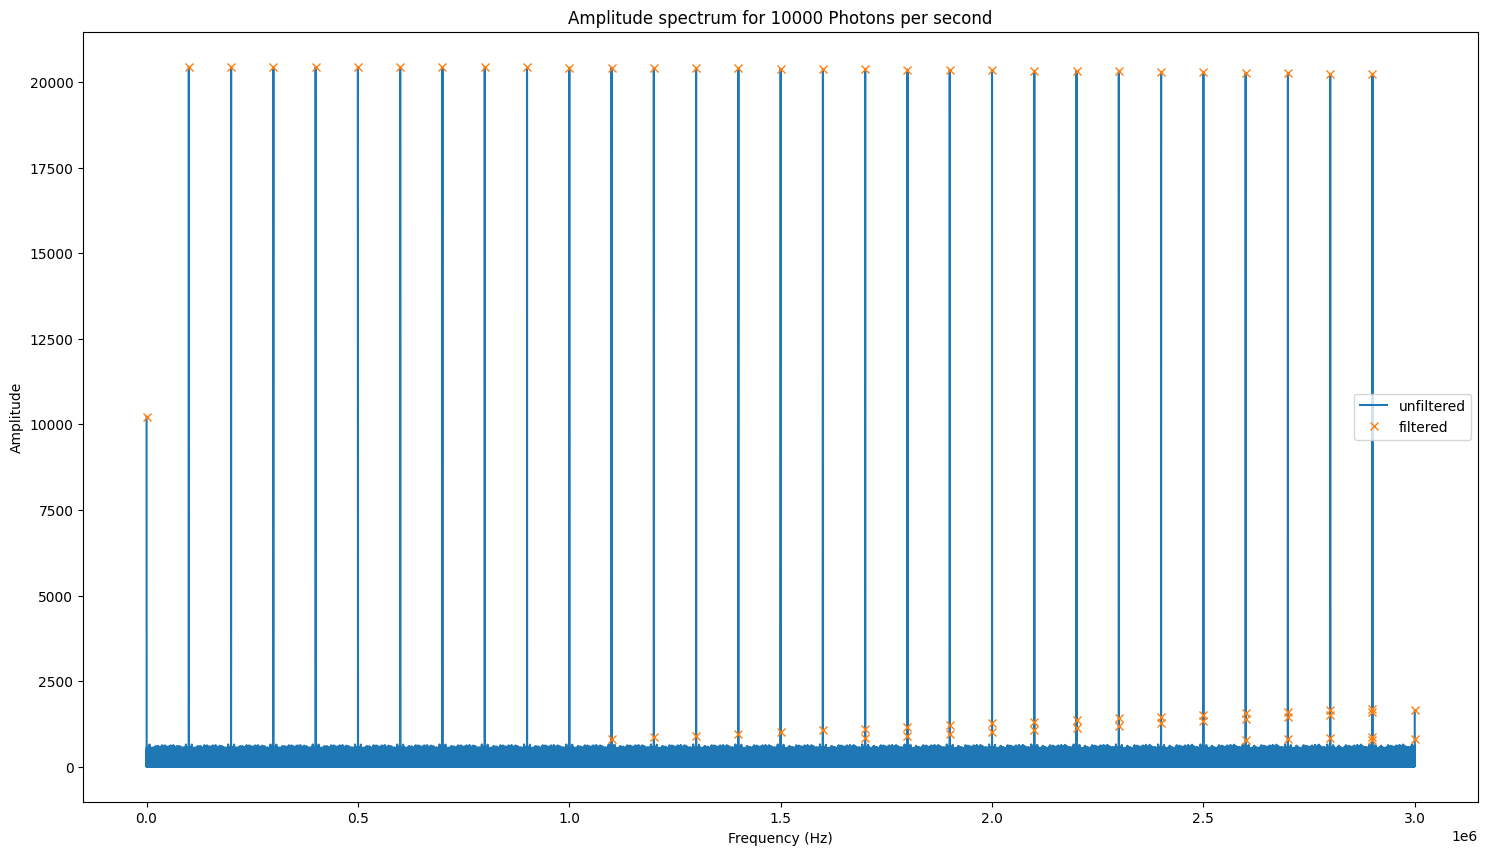

In [3]:
from probe import probe
from utils import (compute_coefficients_sweep_torch, 
                   compute_bound_torch, 
                   compute_amplitude_bound, 
                   reconstruct_rate_function_torch)
import torch
import torch.nn.functional as F

freq = 2.43E6 # 3 2.43 MHz
phase = 0
T = 1 # Probe time
# ts = torch.linspace(0, T, 1000)
freqs = torch.arange(0, 3E6, 1/T)
perc_accept = 1 - 1 / freqs.shape[0]

# bound_val = compute_bound_torch(freqs, timestamps, 1, T)

sig_vals = {}
val= 10000
timestamps = torch.from_numpy(generateStamps(val, freq, phase, rateSinu, T))
precision = 1E-5
timestamps = np.round(timestamps / precision) * precision
print(len(timestamps))
amp_bound = compute_amplitude_bound(percentage_in=perc_accept, counts_per_sec=timestamps.shape[0]/(timestamps[-1] * T))
print(f'Amplitude bound: {amp_bound}')
ampl, phs = compute_coefficients_sweep_torch(time_total=T, 
                                freq=freqs, 
                                stamps=timestamps, 
                                device='cpu')
sig_vals[val] = (ampl, phs, timestamps)

fig, ax = plt.subplots(1, 1, figsize=(18, 10))
ampl, phs, _ = sig_vals[val]
bound_mask = (ampl > amp_bound).flatten()
ax.plot(freqs, ampl, label=f'unfiltered')
ax.plot(freqs[bound_mask], ampl[bound_mask], 'x', label=f'filtered')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
ax.set_title(f'Amplitude spectrum for {val} Photons per second')
ax.legend()
fig.savefig('amplitude_spectrum_Sotiris.png')

# fig, ax = plt.subplots(len(vals), 1, figsize=(10, 18))
# for i, val in enumerate(vals):
#     ampl, phs, timestamps = sig_vals[val]
#     # Plot Reconstructions
#     rate_recon_bounded = reconstruct_rate_function_torch(times = ts, 
#                                                 max_freq=max(freqs[bound_mask]), 
#                                                 frequencies=freqs[bound_mask],
#                                                 amplitudes=ampl[bound_mask],
#                                                 phases=phs[bound_mask],)
#     rate_recon_unbounded = reconstruct_rate_function_torch(times = ts,
#                                                 max_freq=max(freqs),
#                                                 frequencies=freqs,
#                                                 amplitudes=ampl,
#                                                 phases=phs,)
#     ax[i].plot(ts, rate_recon_unbounded, label='unfiltered recon')
#     ax[i].plot(ts, rate_recon_bounded, label='filtered recon')
#     ax[i].plot(ts, rateSinu(ts, val, freq, phase)[1], label='True rate function')
#     # right axis plot timestamps
#     ax2 = ax[i].twinx()
#     ax2.scatter(timestamps, np.ones_like(timestamps), marker='o', s=15, edgecolors='r', facecolors='none', label='timestamps')
#     ax2.legend(loc='upper right')
#     ax2.set_ylabel('Timestamps')
#     ax[i].set_xlabel('Time (s)')
#     ax[i].set_ylabel('Rate function')
#     ax[i].set_title(f'Reconstruction of Rate function for {val} Photons per second')
#     ax[i].legend(loc='upper left')
# plt.savefig('reconstruction.png')

# fig, ax = plt.subplots(len(vals), 1, figsize=(10, 18))
# ts = torch.linspace(0, T/5, 10000)
# for i, val in enumerate(vals):
#     ampl, phs, _ = sig_vals[val]
#     # Plot Reconstructions
#     rate_recon_bounded = reconstruct_rate_function_torch(times = ts, 
#                                                 max_freq=max(freqs[bound_mask]), 
#                                                 frequencies=freqs[bound_mask],
#                                                 amplitudes=ampl[bound_mask],
#                                                 phases=phs[bound_mask],)
#     ax[i].plot(ts, rate_recon_bounded, label='filtered recon')
#     mse_loss = F.mse_loss(rate_recon_bounded, rateSinu(ts, val, freq, phase)[1])
#     ax[i].plot(ts, rateSinu(ts, val, freq, phase)[1], label='True rate function')
#     # ax[i].text(0.5, 0.5, f"MSE: {mse_loss.item()}", transform=ax[i].transAxes )
#     ax[i].set_ylabel('Rate function')
#     ax[i].set_title(f'Reconstruction of Rate function for {val} Photons per second')
#     ax[i].legend()
# plt.savefig('reconstruction_filtered.png')


# plt.show()


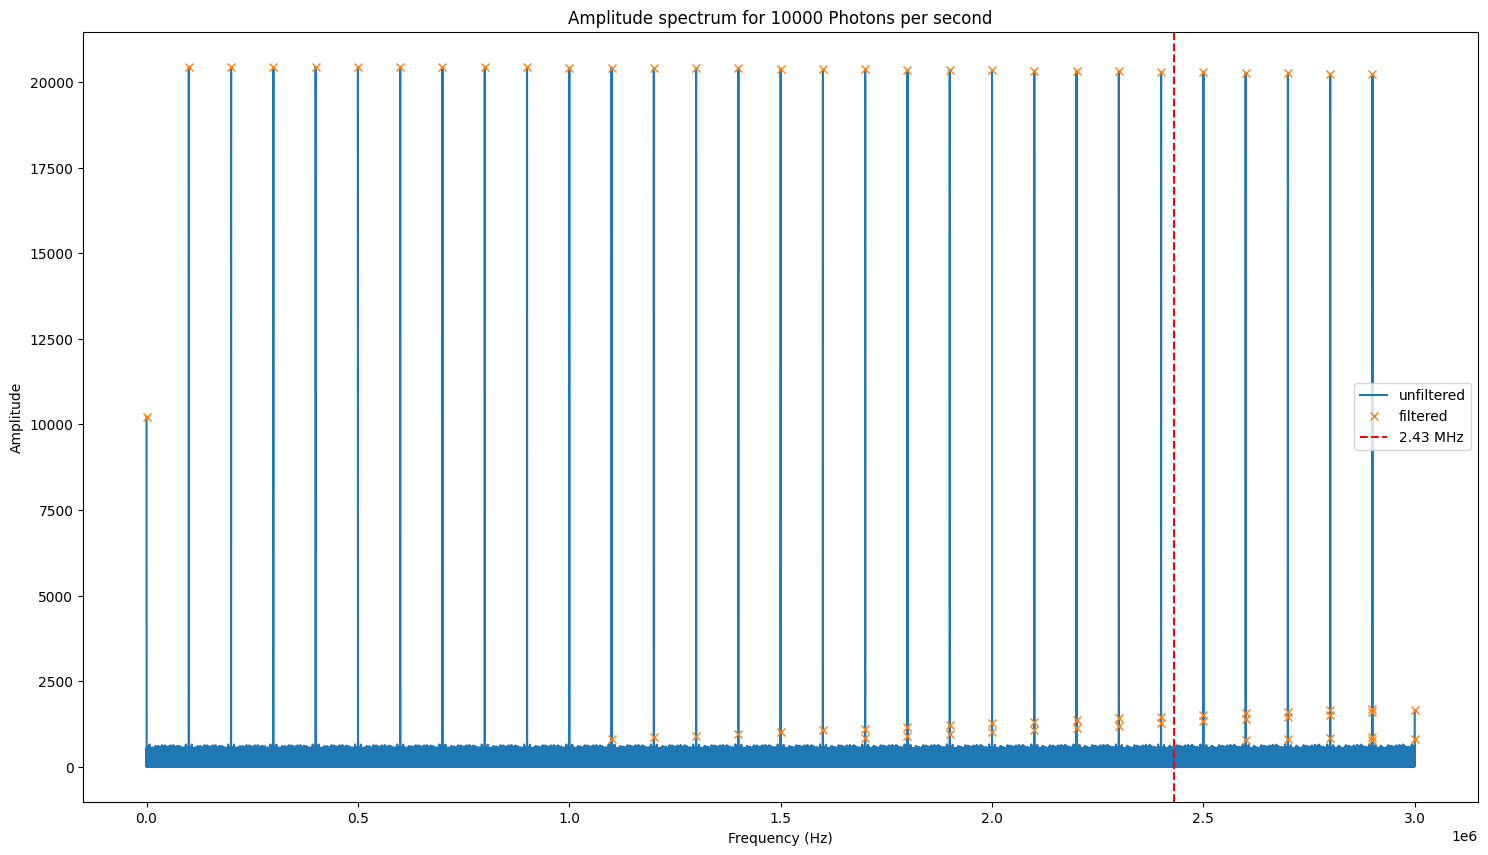

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10))
ampl, phs, _ = sig_vals[val]
bound_mask = (ampl > amp_bound).flatten()
ax.plot(freqs, ampl, label=f'unfiltered')
ax.plot(freqs[bound_mask], ampl[bound_mask], 'x', label=f'filtered')
ax.axvline(x=2.43E6, color='r', linestyle='--', label='2.43 MHz')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
ax.set_title(f'Amplitude spectrum for {val} Photons per second')
ax.legend()
fig.savefig('amplitude_spectrum_Sotiris.png')


## Contribution Ratio limits

In [9]:
import pandas as pd

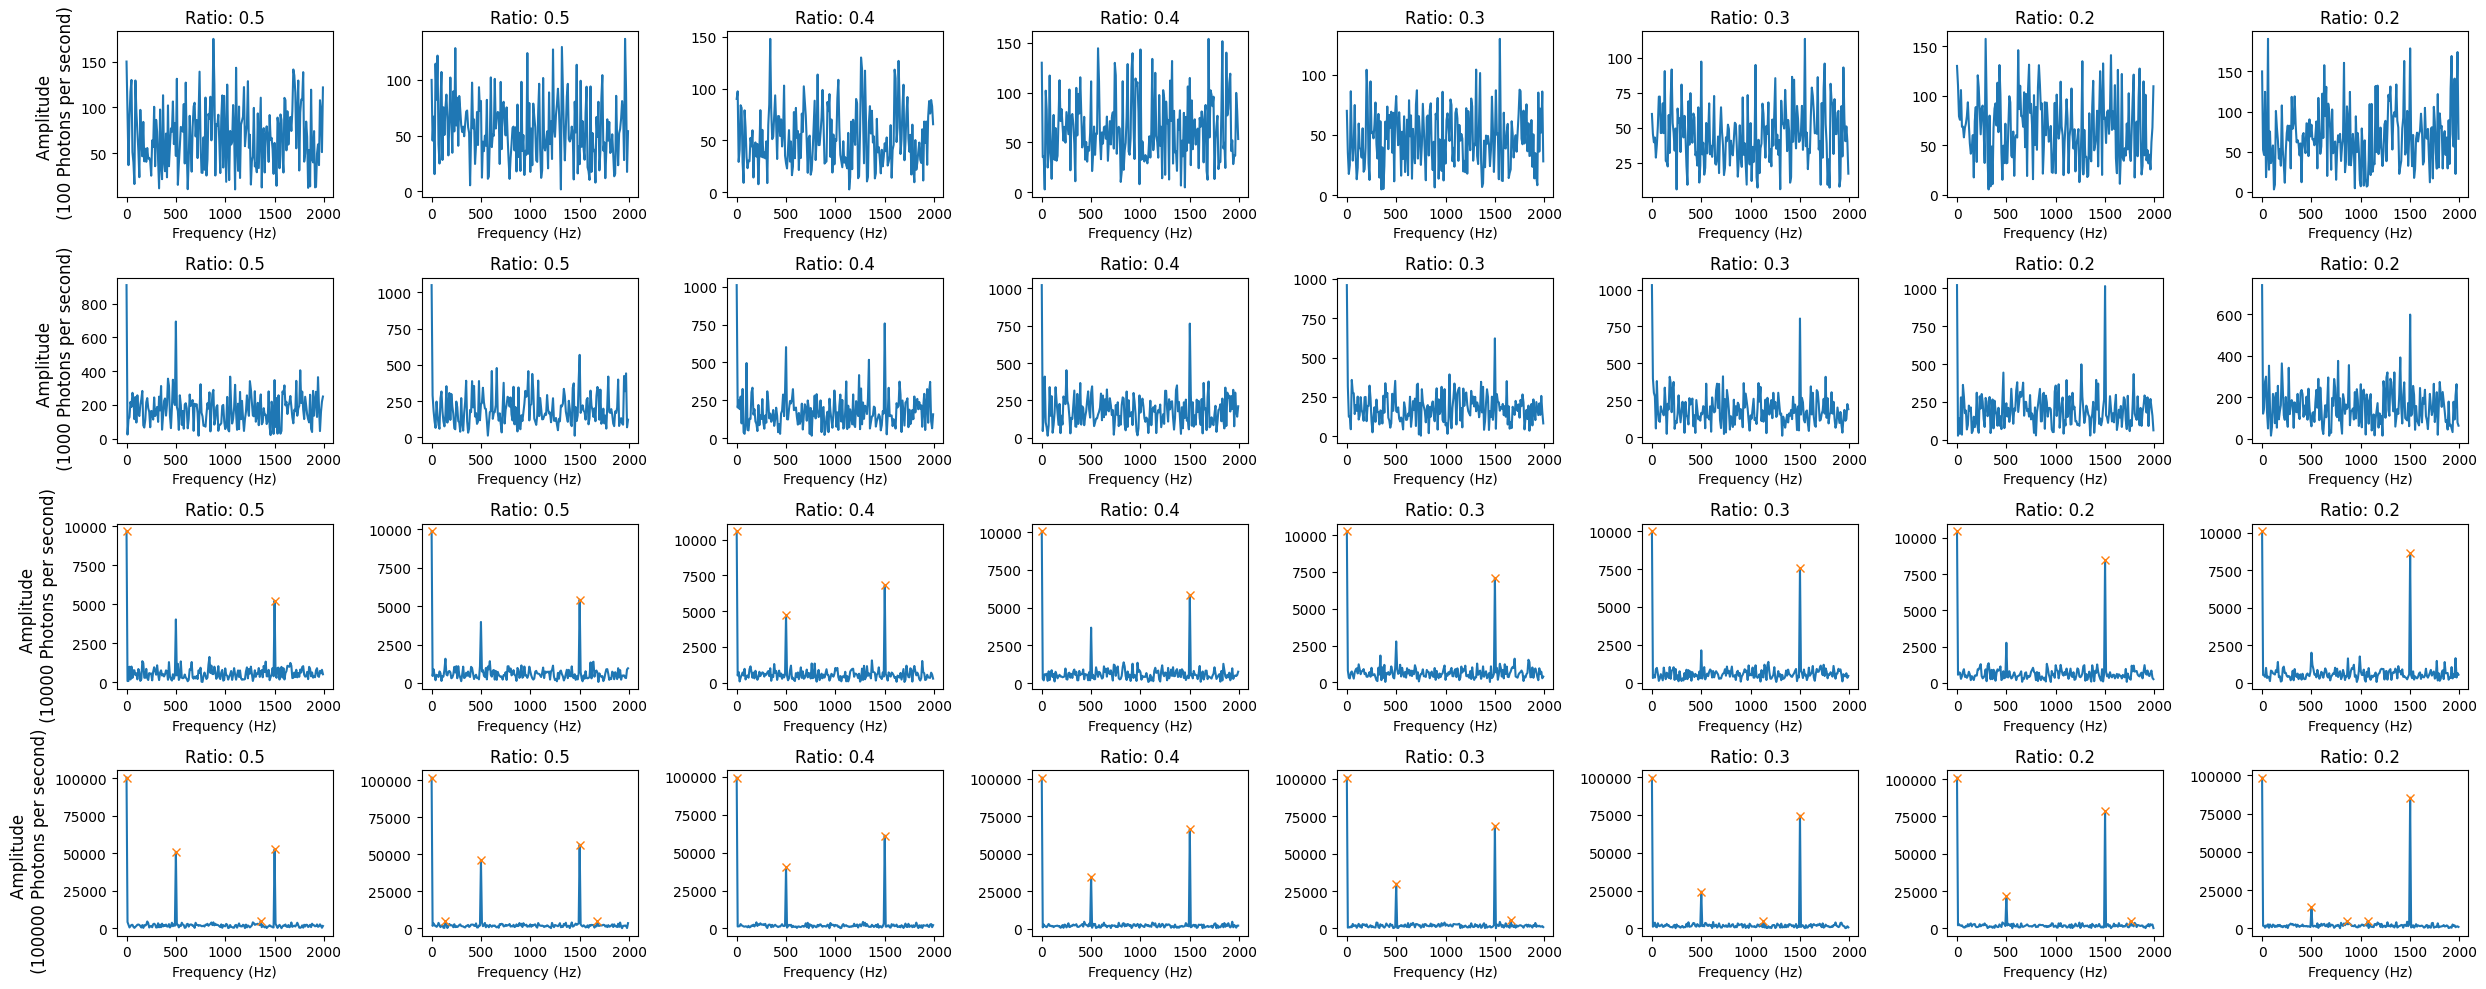

In [26]:
from probe import probe
from utils import (compute_coefficients_sweep_torch, 
                   compute_bound_torch, 
                   compute_amplitude_bound, 
                   reconstruct_rate_function_torch)
import torch
import torch.nn.functional as F

freq = (500, 1500) # 3 kHz
phase = 0
T = 0.1 # Probe time
ts = torch.linspace(0, T, 1000)
freqs = torch.arange(0, 2000, 1/T)
false_pos_rate = 0.05
perc_accept = 1- false_pos_rate
perc_accept = 1 - 1 / freqs.shape[0]

# bound_val = compute_bound_torch(freqs, timestamps, 1, T)

sig_vals = {}
vals = [100, 1000, 10000, 100000]
ratios = np.arange(0.5,0.1,-0.05)
for i, val in enumerate(vals):
    for j, ratio in enumerate(ratios):
        stamps1 = generateStamps(ratio*val, freq[0], phase, rateSinu, T)
        stamps2 = generateStamps((1-ratio)*val, freq[1], phase, rateSinu, T)
        timestamps = torch.from_numpy(np.concatenate([stamps1, stamps2])).sort()[0]
        # print(len(timestamps))
        amp_bound = compute_amplitude_bound(percentage_in=perc_accept, counts_per_sec=timestamps.shape[0]/(timestamps[-1] * T))
        # print(f'Amplitude bound: {amp_bound}')
        ampl, phs = compute_coefficients_sweep_torch(time_total=T, 
                                        freq=freqs, 
                                        stamps=timestamps, 
                                        device='cpu',
                                        verbose=False)
        sig_vals[(val, ratio)] = (ampl, phs, timestamps)

fig, ax = plt.subplots(len(vals), len(ratios), figsize=(25, 10))
for i, val in enumerate(vals):
    for j, ratio in enumerate(ratios):
        ampl, phs, _ = sig_vals[(val, ratio)]
        bound_mask = (ampl > amp_bound).flatten()
        ax[i, j].plot(freqs, ampl, label=f'unfiltered')
        ax[i, j].plot(freqs[bound_mask], ampl[bound_mask], 'x', label=f'filtered')
        ax[i, j].set_xlabel('Frequency (Hz)')
        # ax[i, j].set_ylabel('Amplitude')
        ax[i, j].set_title(f'Ratio: {ratio:.1f}')
        # ax[i, j].legend()
    ax[i, 0].set_ylabel(f'Amplitude\n({vals[i]} Photons per second)', fontsize=12)
plt.subplots_adjust(wspace=0.8, hspace=0.5)
fig.tight_layout()
fig.savefig('ratios_amplitude_spectrum.png')


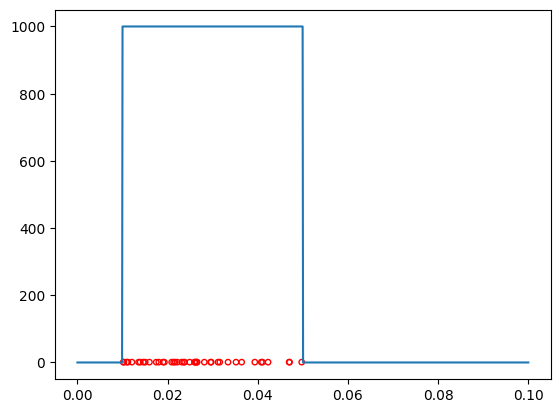

In [8]:
plt.scatter(timestamps, np.ones_like(timestamps), marker='o', s=15, edgecolors='r', facecolors='none', label='timestamps')
ts = torch.linspace(0, T, 1000)
plt.plot(ts, [func(t) for t in ts], label='True rate function')

Amplitude bound: 109.45518957156884


100%|██████████| 10/10 [00:00<00:00, 3097.03it/s]

Amplitude bound: 243.6470143252366


100%|██████████| 50/50 [00:00<00:00, 2056.52it/s]


Amplitude bound: 340.8328407192721


100%|██████████| 4999/4999 [00:00<00:00, 43412.50it/s]


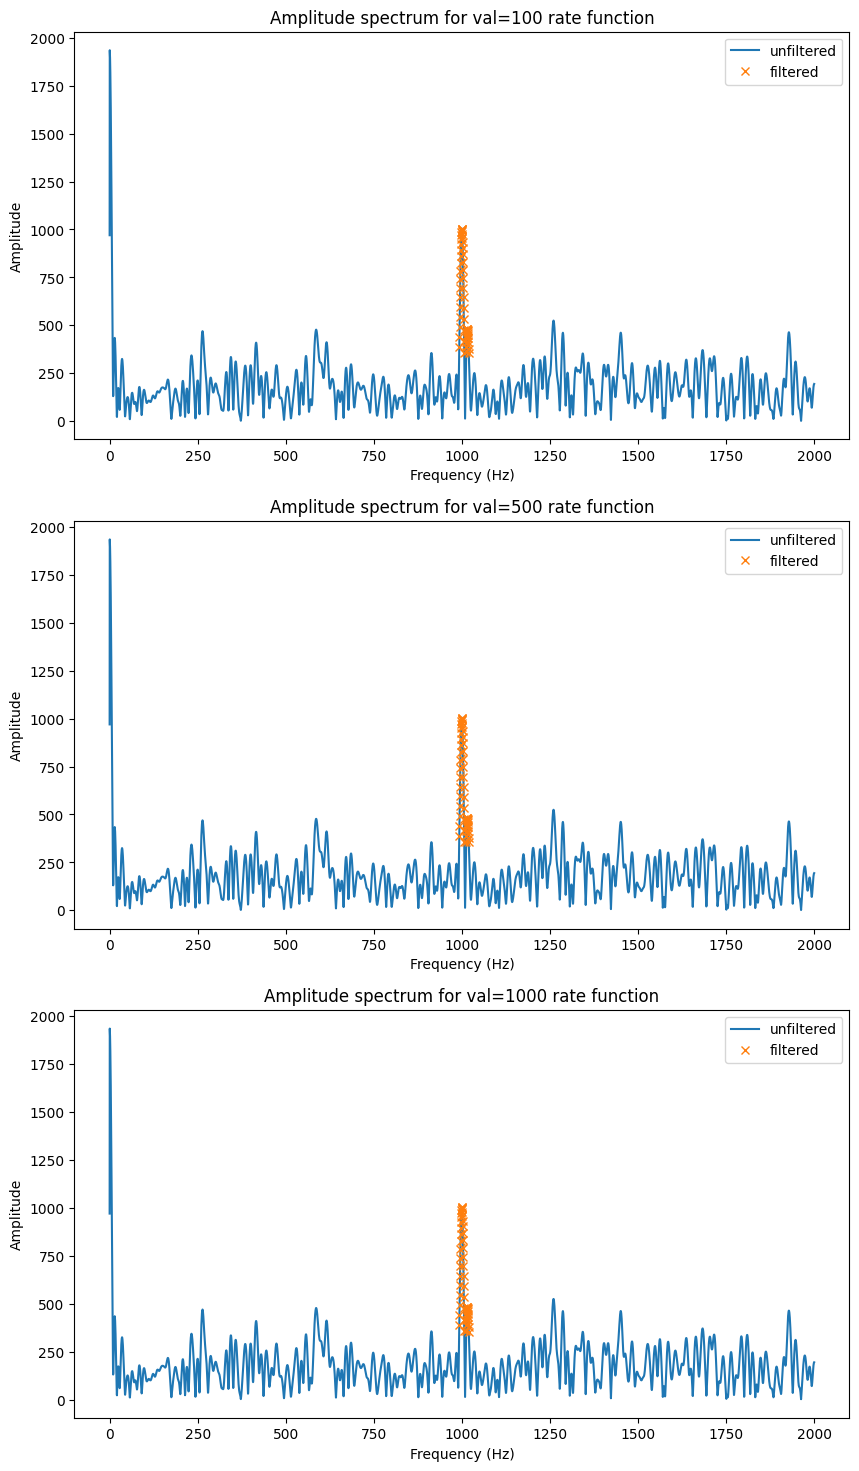

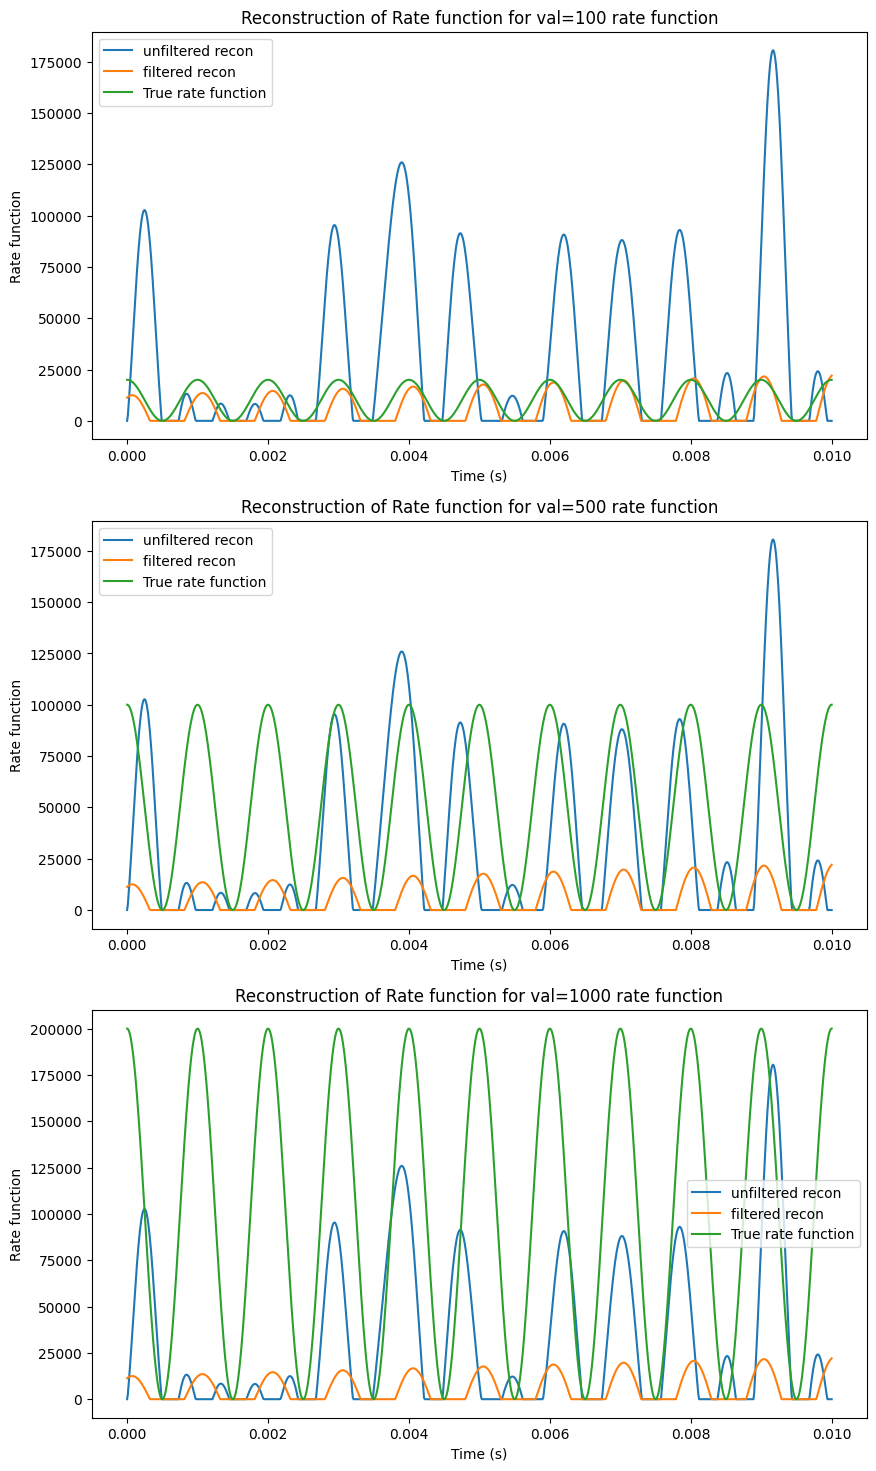

In [ ]:
freq = 1E3 # 3 kHz
phase = 0
T = 0.1 # Probe time
ts = torch.linspace(0, 0.01, 1000)
freqs = torch.linspace(0, 2E3, 5000)
false_pos_rate = 0.05
perc_accept = 1- false_pos_rate

# bound_val = compute_bound_torch(freqs, timestamps, 1, T)

sig_vals = {}
vals = [100, 500, 1000]
for i, val in enumerate(vals):
    timestamps = torch.from_numpy(generateStamps(val, freq, phase, rateSinu, T))
    amp_bound = compute_amplitude_bound(percentage_in=perc_accept, counts_per_sec=timestamps.shape[0]/(timestamps[-1] * T))
    print(f'Amplitude bound: {amp_bound}')
    ampl, phs = compute_coefficients_sweep_torch(time_total=T, 
                                    freq=freqs, 
                                    stamps=timestamps, 
                                    device='cpu')
    sig_vals[val] = (ampl, phs)

bandpass = (freqs >= 990) & (freqs <= 1100)

fig, ax = plt.subplots(3, 1, figsize=(10, 18))
for i, val in enumerate(vals):
    bound_mask = (ampl >= amp_bound).flatten()
    bound_mask = bound_mask & bandpass
    ax[i].plot(freqs, ampl, label=f'unfiltered')
    ax[i].plot(freqs[bound_mask], ampl[bound_mask], 'x', label=f'filtered')
    ax[i].set_xlabel('Frequency (Hz)')
    ax[i].set_ylabel('Amplitude')
    ax[i].set_title(f'Amplitude spectrum for {val=} rate function')
    ax[i].legend()
fig.savefig('amplitude_spectrum.png')

fig, ax = plt.subplots(3, 1, figsize=(10, 18))
for i, val in enumerate(vals):
    # Plot Reconstructions
    rate_recon_bounded = reconstruct_rate_function_torch(times = ts, 
                                                max_freq=max(freqs[bound_mask]), 
                                                frequencies=freqs[bound_mask],
                                                amplitudes=ampl[bound_mask],
                                                phases=phs[bound_mask],)
    rate_recon_unbounded = reconstruct_rate_function_torch(times = ts,
                                                max_freq=max(freqs),
                                                frequencies=freqs,
                                                amplitudes=ampl,
                                                phases=phs,)
    ax[i].plot(ts, rate_recon_unbounded, label='unfiltered recon')
    ax[i].plot(ts, rate_recon_bounded, label='filtered recon')
    ax[i].plot(ts, 100 * rateSinu(ts, val, freq, phase)[1], label='True rate function')
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('Rate function')
    ax[i].set_title(f'Reconstruction of Rate function for {val=} rate function')
    ax[i].legend()
plt.savefig


plt.show()


In [ ]:
from vishelper import generateStampsGeneralFunc

freq = 1E3 # 3 kHz
freq2 = 700
phase = 0
T = 0.1 # Probe time
ts = torch.linspace(0, 0.01, 1000)
freqs = torch.linspace(0, 2E3, 5000)
false_pos_rate = 0.05
perc_accept = 1- false_pos_rate



NameError: name 'torch' is not defined

### With CFAR freqeuncies bounds

# Walk through UWB1 example experiment step by step

In [ ]:
np.arange(0, intervals[i], 1)

IndexError: list index out of range

## Demystifying probe()

In [ ]:
# Finding how max size and intervals work within probing

max_sizes = [2E9]
intervals = [10]
stepsize = 1

i = 0
for curMax in np.arange(0, intervals[i], 1):
    maxFreq = (curMax+1)*max_sizes[i]
    if curMax == 0:
        minFreq = 0
    elif maxFreq == 2e9: 
        minFreq = 1e9 + stepsize
    else:
        minFreq = curMax*max_sizes[i] + stepsize # TODO: if not first iteration and not maxFreq == 2e9, (maxFreq - minFreq) = max_sizes[i] - stepsize

    print(f'{minFreq=:.2e}, {maxFreq=:.2e}')

minFreq=0.00e+00, maxFreq=2.00e+09
minFreq=2.00e+09, maxFreq=4.00e+09
minFreq=4.00e+09, maxFreq=6.00e+09
minFreq=6.00e+09, maxFreq=8.00e+09
minFreq=8.00e+09, maxFreq=1.00e+10
minFreq=1.00e+10, maxFreq=1.20e+10
minFreq=1.20e+10, maxFreq=1.40e+10
minFreq=1.40e+10, maxFreq=1.60e+10
minFreq=1.60e+10, maxFreq=1.80e+10
minFreq=1.80e+10, maxFreq=2.00e+10


## Visualize given file

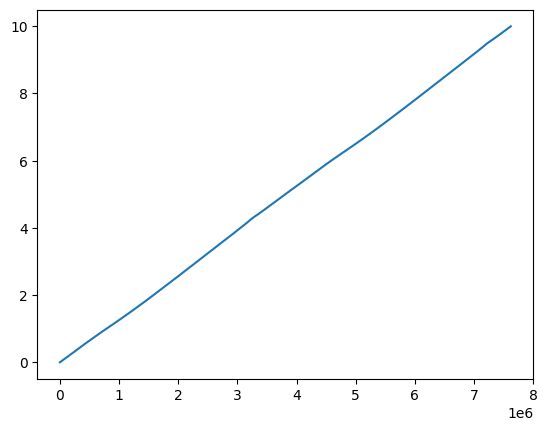

In [ ]:
import h5py
import scipy.io as sio
from constants import EXPERIMENT, PROBE_FILE
from pathlib import Path

data = sio.loadmat(dir_path/EXPERIMENT/PROBE_FILE) # Load the probe file
plt.plot(data['data_2'])



In [ ]:
data['data_2'].shape

(7620799, 1)

## Probe

In [ ]:
probe_args = {'probe_times': [0.1, 1], 
            'max_sizes': [400e6, 40e6], 
            'intervals': [25, 1], 
            'stepsizes': [6, 1]}
probe(**probe_args)

Probing for 0.1 seconds
Bound: 8132.5203848054025
Min Freq: 0.0, Max Freq: 400000002.0


  1%|          | 55/7786 [04:29<10:30:56,  4.90s/it]


KeyboardInterrupt: 